In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install triton 
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [2]:
import triton
import triton.language as tl
import torch 
import torch.nn.functional as F

In [3]:
DEVICE = torch.device(f'cuda:{0}')

In [4]:
@triton.jit
def layer_norm_kernel(x_ptr,y_ptr,weight_ptr,bias_ptr,mean_ptr,std_ptr,M,N,eps:tl.constexpr,BLOCK_SIZE:tl.constexpr):
    """
    #xptr - data ptr to the xarray (M,N)
    #y_ptr - output ptr to store LN (M,N)
    #weight_ptr - shape (N,)
    #bias_ptr - shape (N,)
    #std_ptr - shape (N,)
    #mean_ptr - shape (N,)
    # M - DIM 0 OF X 
    # N - DIM 1 OF X 
    eps - const to not div / 0
    BLOCK_SIZE - elements to load from sram into sm's cache in block size length 
    VAR - (E(X**2)-(E(X))**2)
    yx+b
    """
    row_id  = tl.program_id(axis=0) # 0 1 2 3 M rows 
    x_ptr_moved = x_ptr + row_id * N
    y_ptr_moved = y_ptr + row_id * N
    mean = 0.0
    var = 0.0
    for idx in tl.range(0,N,BLOCK_SIZE):
        offsets =   idx + tl.arange(0,BLOCK_SIZE)
        mask = offsets < N 
        x_data = tl.load(x_ptr_moved+offsets,mask=mask,other=0)
        mean += tl.sum(x_data,axis=0)
        var += tl.sum(x_data*x_data,axis=0)
    mean  = (mean/N)
    var  = (var/N)-((mean*mean))
    #yx+b -  x = (x-u)/underoot(sigma+eps)
    rstd = 1 / tl.sqrt(var+eps)
    tl.store(mean_ptr+row_id,mean)
    tl.store(std_ptr+row_id,rstd)

    for idx in tl.range(0,N,BLOCK_SIZE):
        offsets =  idx+ tl.arange(0,BLOCK_SIZE)
        mask = offsets < N 
        x_data = tl.load(x_ptr_moved+offsets,mask=mask,other=0)
        weight_data = tl.load(weight_ptr+offsets,mask=mask,other=0)
        bias_data = tl.load(bias_ptr+offsets,mask=mask,other=0)
        x_data = (x_data - mean) * rstd 
        output = weight_data * x_data + bias_data
        tl.store(y_ptr_moved+offsets,output,mask=mask)
        
    
@triton.jit
def layer_norm_backward_kernel(dy_ptr,x_ptr,mean_ptr,rstd_ptr,weight_ptr,dx_ptr,dweight_ptr,dbias_ptr,M,N,BLOCK_SIZE:tl.constexpr):
    """
    dy_ptr is our ptr for dl/dy coming from outside 
    x_ptr is our ptr for x_data M,N
    mean_ptr is our ptr for mean shaped N,
    rstd_ptr is our ptr for std shaped N,
    weight_ptr is our ptr shaped N,
    dx_ptr is our ptr to x jacobian shapes (M,N)
    dweight_ptr is our ptr to weight lambda shaped (M,N) later we sum accross N to get shape N grad
    dbias_ptr is our ptr to bias again shaped (M,N) rem for bias derivative is sum of yij accross rows
    """
    row_id = tl.program_id(axis=0)
    mean = tl.load(mean_ptr+row_id)
    rstd = tl.load(rstd_ptr+row_id)

    sum_dy = 0.0
    sum_dy_xhat = 0.0

    for off in tl.arange(0,N,BLOCK_SIZE):
        col_offsets = off + tl.arange(0,BLOCK_SIZE)
        mask = col_offsets < N 
        dy = tl.load(dy_ptr+ row_id * N + col_offsets,mask=mask,other= 0.0)
        x = tl.load(x_ptr+ row_id * N + col_offsets,mask=mask,other= 0.0)
        x_hat = (x-mean)*rstd
        sum_dy += tl.sum(dy,mask=mask)
        sum_dy_xhat += tl.sum(dy*x_hat,mask=mask)
        

    for off in tl.arange(0,N,BLOCK_SIZE):
        col_offsets = off+tl.arange(0,BLOCK_SIZE)
        mask = col_offsets < N
        dy = tl.load(dy_ptr+ row_id * N + col_offsets,mask=mask,other= 0.0)
        x = tl.load(x_ptr+ row_id * N + col_offsets,mask=mask,other= 0.0)
        x_hat = (x-mean)*rstd
        gamma = tl.load(weight_ptr+col_offsets,mask=mask,other=0.0)
        dx = gamma * rstd * (dy-sum_dy/N-x_hat*(sum_dy_xhat/N))
        tl.store(dx_ptr+row_id*N+col_offsets,dx,mask=mask)

        dgamma_partial = dy*x_hat
        dbias_partial = dy 
        tl.store(dgamma_partial_ptr + row_id * N + col_offsets, dgamma_partial, mask=mask)
        tl.store(dbias_partial_ptr + row_id * N + col_offsets, dbias_partial, mask=mask)
        
        
        


        
    

In [5]:
def flops(M,N):
    return 7*M*N

def layer_norm(A:torch.Tensor,weight:torch.Tensor,bias:torch.Tensor,eps:int=1e-6):
    #a -> m,n -> m,n (norm)
    M,N = A.shape
    y = torch.empty_like(A)
    mean = torch.empty(M,dtype=torch.float32,device=A.device) #for layer norm we only store means for each row 
    std = torch.empty_like(mean) # for this as well we only store for each row 
    grid = (M,) #each row per program 
    block_size = triton.next_power_of_2(N)
    layer_norm_kernel[grid](
        A,y,weight,bias,mean,std,M,N,eps=eps,BLOCK_SIZE = block_size
    )
    return y
    
    

In [66]:



def test_layer_norm_kernel(size:int,atol=1e-3,rtol=1e-3):
    A = torch.randn(size,size).to(DEVICE) #bs,seqlen - > #bs,seq_len,ndim
    weight = torch.randn((size)).to(DEVICE)
    bias = torch.zeros((size)).to(DEVICE)
    a_tri = layer_norm(A,weight,bias,eps=1e-6)
    a_torch = F.layer_norm(A,(size,),weight,bias,eps=1e-6)
    
    assert torch.allclose(a_tri,a_torch,atol=atol,rtol=rtol)
    return a_tri,a_torch

In [67]:
a_tri,a_torch = test_layer_norm_kernel(4096)

In [68]:
import triton.testing  

def test_layer_norm_kernel_return_ms(size:int,atol=1e-3,rtol=1e-3):
    A = torch.randn(size,size).to(DEVICE) #bs,seqlen - > #bs,seq_len,ndim
    weight = torch.randn((size)).to(DEVICE)
    bias = torch.zeros((size)).to(DEVICE)
    a_tri = layer_norm(A,weight,bias,eps=1e-6)
    a_torch = F.layer_norm(A,(size,),weight,bias,eps=1e-6)
    flops_val = flops(size,size)
    triton_s  = triton.testing.do_bench(lambda: layer_norm(A,weight,bias,eps=1e-6)) * 0.001
    torch_s  = triton.testing.do_bench(lambda: F.layer_norm(A,(size,),weight,bias,eps=1e-6)) * 0.001
    return (flops_val/triton_s)/1e12,(flops_val/torch_s)/1e12

In [69]:
a_tri,a_torch = test_layer_norm_kernel_return_ms(4096)

In [70]:
size = sizes = [128, 256, 512, 1024, 2048, 4096,12000,14000]
times = [ test_layer_norm_kernel_return_ms(i) for i in size]

In [71]:
import matplotlib.pyplot as plt

torch_flops = [i[1] for i in times]
triton_flops = [i[0] for i in times]


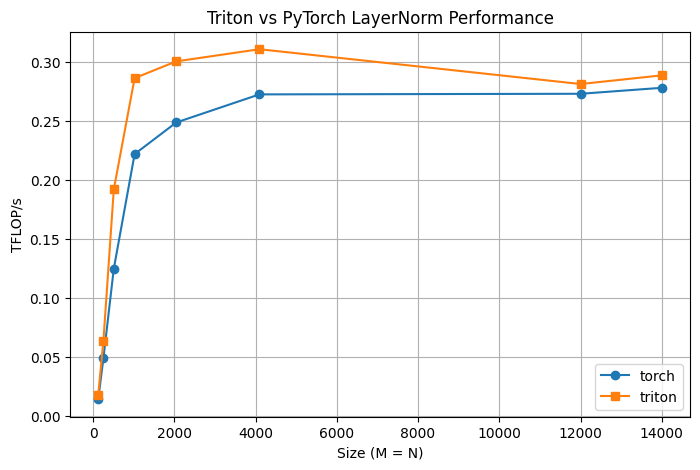

In [72]:
plt.figure(figsize=(8,5))
plt.plot(size, torch_flops,  marker='o', label='torch')
plt.plot(size, triton_flops, marker='s', label='triton')
plt.xlabel('Size (M = N)')
plt.ylabel('TFLOP/s')
plt.title('Triton vs PyTorch LayerNorm Performance')
plt.legend(); plt.grid(True)
plt.savefig('data.png')

<Figure size 640x480 with 0 Axes>